In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import models, datasets
from torchvision import transforms as T
import os
from random import randint


# Define device to use (CPU or GPU). CUDA = GPU support for PyTorch
devices = ['cuda:0', 'cuda:1', 'cuda:2', 'cuda:3', 'cuda:4', 'cuda:5']

DATA_DIR = '../tiny-imagenet-200' 
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALID_DIR = os.path.join(DATA_DIR, 'val')

In [2]:
# Functions to display single or a batch of sample images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_batch(dataloader):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    imshow(make_grid(images)) # Using Torchvision.utils make_grid function

def show_image(dataloader):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    random_num = randint(0, len(images)-1)
    imshow(images[random_num])
    label = labels[random_num]
    print(f'Label: {label}, Shape: {images[random_num].shape}')

# Setup function to create dataloaders for image datasets
def generate_dataloader(data, name, transform, use_cuda):
    if data is None:
        return None

    # Read image files to pytorch dataset using ImageFolder, a generic data
    # loader where images are in format root/label/filename
    # See https://pytorch.org/vision/stable/datasets.html
    if transform is None:
        dataset = datasets.ImageFolder(data, transform=T.ToTensor())
    else:
        dataset = datasets.ImageFolder(data, transform=transform)

    # Set options for device
    if use_cuda:
        kwargs = {"pin_memory": True, "num_workers": 1}
    else:
        kwargs = {}

    # Wrap image dataset (defined above) in dataloader
    dataloader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=(name=="train"),
                        **kwargs)

    return dataloader

In [3]:
val_data = pd.read_csv(f'{VALID_DIR}/val_annotations.txt',sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.head()

File      Class   X   Y   H   W
0  val_0.JPEG  n03444034   0  32  44  62
1  val_1.JPEG  n04067472  52  55  57  59
2  val_2.JPEG  n04070727   4   0  60  55
3  val_3.JPEG  n02808440   3   3  63  63
4  val_4.JPEG  n02808440   9  27  63  48

In [4]:
# Create separate validation subfolders for the validation images based on
# their labels indicated in the val_annotations txt file
val_img_dir = os.path.join(VALID_DIR, 'images')

# Open and read val annotations text file
fp = open(os.path.join(VALID_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()

# Create dictionary to store img filename (word 0) and corresponding
# label (word 1) for every line in the txt file (as key value pair)
val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()

# Display first 10 entries of resulting val_img_dict dictionary
{k: val_img_dict[k] for k in list(val_img_dict)[:10]}

{'val_0.JPEG': 'n03444034',
 'val_1.JPEG': 'n04067472',
 'val_2.JPEG': 'n04070727',
 'val_3.JPEG': 'n02808440',
 'val_4.JPEG': 'n02808440',
 'val_5.JPEG': 'n04399382',
 'val_6.JPEG': 'n04179913',
 'val_7.JPEG': 'n02823428',
 'val_8.JPEG': 'n04146614',
 'val_9.JPEG': 'n02226429'}

In [5]:
# Create subfolders (if not present) for validation images based on label ,
# and move images into the respective folders
for img, folder in val_img_dict.items():
    newpath = (os.path.join(val_img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_img_dir, img)):
        os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))

In [6]:
# Save class names (for corresponding labels) as dict from words.txt file
class_to_name_dict = dict()
fp = open(os.path.join(DATA_DIR, 'words.txt'), 'r')
data = fp.readlines()
for line in data:
    words = line.strip('\n').split('\t')
    class_to_name_dict[words[0]] = words[1].split(',')[0]
fp.close()

# Display first 20 entries of resulting dictionary
{k: class_to_name_dict[k] for k in list(class_to_name_dict)[:20]}

{'n00001740': 'entity',
 'n00001930': 'physical entity',
 'n00002137': 'abstraction',
 'n00002452': 'thing',
 'n00002684': 'object',
 'n00003553': 'whole',
 'n00003993': 'congener',
 'n00004258': 'living thing',
 'n00004475': 'organism',
 'n00005787': 'benthos',
 'n00005930': 'dwarf',
 'n00006024': 'heterotroph',
 'n00006150': 'parent',
 'n00006269': 'life',
 'n00006400': 'biont',
 'n00006484': 'cell',
 'n00007347': 'causal agent',
 'n00007846': 'person',
 'n00015388': 'animal',
 'n00017222': 'plant'}

In [7]:
preprocess_transform = T.Compose([
                T.Resize(256), # Resize images to 256 x 256
                T.CenterCrop(224), # Center crop image
                T.RandomHorizontalFlip(),
                T.ToTensor(),  # Converting cropped images to tensors
                T.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
])




In [8]:
# Define batch size for data loaders
batch_size = 64
train_loader = generate_dataloader(TRAIN_DIR, "train", transform=preprocess_transform, use_cuda=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


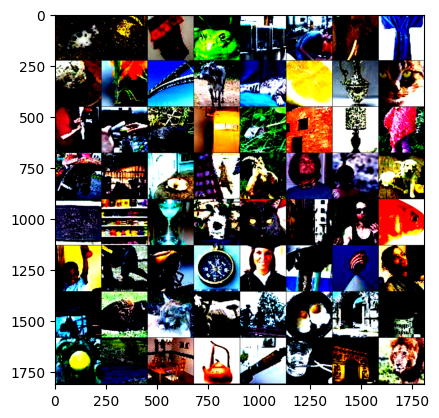

In [9]:
show_batch(train_loader)

In [10]:
# Create dataloaders for validation data (depending if model is pretrained)
val_loader = generate_dataloader(val_img_dir, "val", transform=preprocess_transform, use_cuda=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


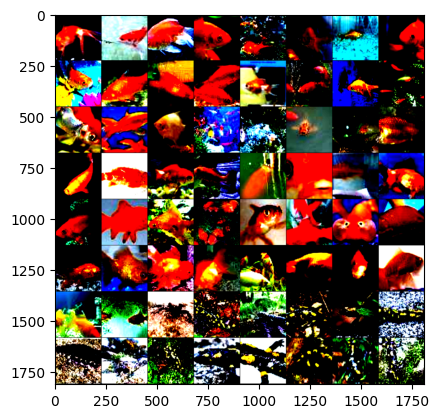

In [11]:
# Display batch of validation images
show_batch(val_loader)

In [12]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import models
import torch.nn.functional as F

In [13]:

import torch
import torchvision
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from torchvision import transforms as T

# Use multiple GPUs if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    num_devices = torch.cuda.device_count()
    devices = [f'cuda:{i}' for i in range(num_devices)]
else:
    devices = [device]

# Load pretrained ResNet model and move it to the GPUs
resnet = torchvision.models.resnet50(pretrained=True)
resnet = torch.nn.DataParallel(resnet, device_ids=list(range(num_devices)))
resnet.to(devices[0])  # Move model to the first GPU

# Feature extraction function
def extract_features(loader, model):
    features, labels = [], []
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(devices[0]), y.to(devices[0])
            feats = model(x)
            features.append(feats.cpu())  # Transfer to CPU
            labels.append(y.cpu())  # Transfer to CPU
    model.train()  # Set the model back to training mode
    return torch.cat(features), torch.cat(labels)

# Extract features using the ResNet model
train_features, train_labels = extract_features(train_loader, resnet)
val_features, val_labels = extract_features(val_loader, resnet)

# Convert the features and labels to NumPy arrays
train_features = train_features.numpy()
train_labels = train_labels.numpy()
val_features = val_features.numpy()
val_labels = val_labels.numpy()

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)

# Set the parameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10],
    'max_iter': [50, 100, 150],
    'solver': ['liblinear', 'lbfgs', 'saga']
}

# Initialize Logistic Regression model
logistic_reg = LogisticRegression()

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(logistic_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_features, train_labels)

# Get the best hyperparameters from the grid search
best_C = grid_search.best_params_['C']
best_max_iter = grid_search.best_params_['max_iter']
best_solver = grid_search.best_params_['solver']

# Train Logistic Regression with the best hyperparameters
logistic_reg = LogisticRegression(C=best_C, max_iter=best_max_iter, solver=best_solver)
logistic_reg.fit(train_features, train_labels)

# Predict on the training and validation sets
train_preds = logistic_reg.predict(train_features)
val_preds = logistic_reg.predict(val_features)

# Evaluate the model
train_acc = accuracy_score(train_labels, train_preds)
val_acc = accuracy_score(val_labels, val_preds)

# Generate classification reports
train_report = classification_report(train_labels, train_preds)
val_report = classification_report(val_labels, val_preds)

print('Best Hyperparameters - C:', best_C, 'max_iter:', best_max_iter, 'solver:', best_solver)
print('Training accuracy:', train_acc)
print('Validation accuracy:', val_acc)

/home/nzb0074@auburn.edu/Nikshep_Home/ML_Project_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nzb0074@auburn.edu/Nikshep_Home/ML_Project_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/nzb0074@auburn.edu/Nikshep_Home/ML_Project_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Hyperparameters - C: 1.0 max_iter: 100 solver: saga
Training accuracy: 0.80374
Validation accuracy: 0.6978


In [14]:
from sklearn.metrics import classification_report, confusion_matrix

print('Training Classification Report:\n', train_report)



Training Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       500
           1       0.90      0.92      0.91       500
           2       0.75      0.76      0.75       500
           3       0.73      0.73      0.73       500
           4       0.72      0.79      0.76       500
           5       0.73      0.76      0.75       500
           6       0.88      0.91      0.90       500
           7       0.73      0.72      0.73       500
           8       0.88      0.87      0.87       500
           9       0.81      0.79      0.80       500
          10       0.75      0.73      0.74       500
          11       0.91      0.89      0.90       500
          12       0.87      0.87      0.87       500
          13       0.89      0.93      0.91       500
          14       0.89      0.88      0.88       500
          15       0.80      0.75      0.77       500
          16       0.75      0.70      0.72     

In [15]:
# Calculate classification report (precision, recall, f1-score, support)
print('Validation Classification Report:\n', val_report)


Validation Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89        50
           1       0.89      0.84      0.87        50
           2       0.58      0.56      0.57        50
           3       0.55      0.56      0.55        50
           4       0.63      0.72      0.67        50
           5       0.47      0.44      0.45        50
           6       0.71      0.84      0.77        50
           7       0.67      0.56      0.61        50
           8       0.78      0.86      0.82        50
           9       0.64      0.64      0.64        50
          10       0.65      0.68      0.67        50
          11       0.80      0.94      0.86        50
          12       0.77      0.82      0.80        50
          13       0.91      0.80      0.85        50
          14       0.75      0.80      0.78        50
          15       0.76      0.58      0.66        50
          16       0.60      0.60      0.60   

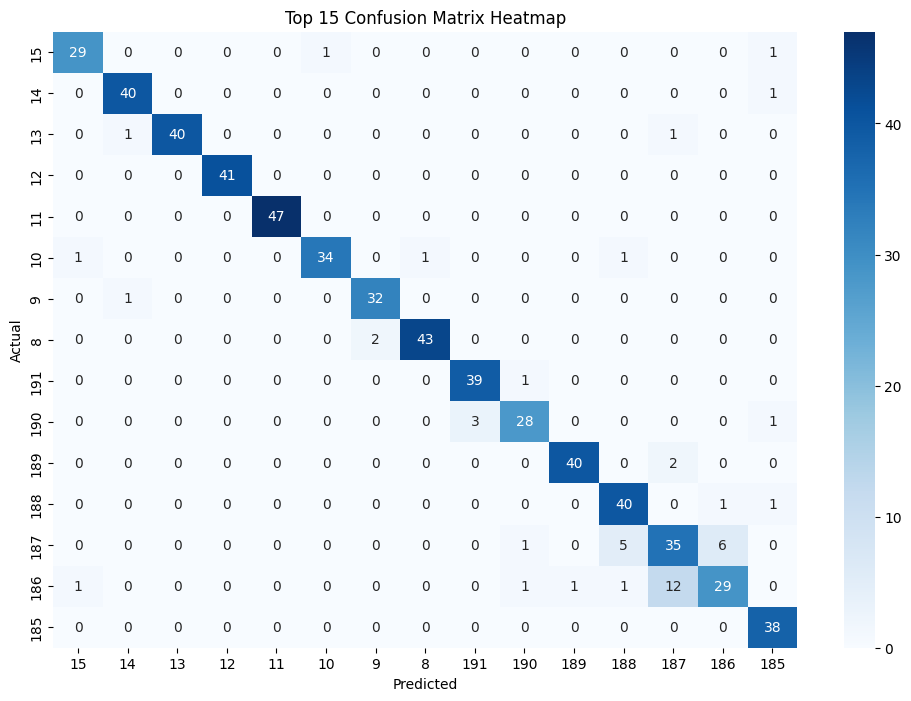

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(val_labels, val_preds)


class_names = [str(i) for i in range(conf_matrix.shape[0])]

# Set the number of top classes to display
top_n_classes = 15  # Change this to the desired number

# Get the indices of the top N classes
top_classes_indices = np.argsort(np.sum(conf_matrix, axis=1))[::-1][:top_n_classes]

# Visualize the confusion matrix for the top N classes
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix[top_classes_indices][:, top_classes_indices], annot=True, fmt='d', cmap='Blues', xticklabels=[class_names[i] for i in top_classes_indices], yticklabels=[class_names[i] for i in top_classes_indices])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Top {top_n_classes} Confusion Matrix Heatmap')
plt.show()

